In [471]:
import matplotlib.pyplot as plt
import seaborn as sns
import params as prm
import pandas as pd
import numpy as np
import torch
import os

## Sans clampage

In [472]:
df_1f = pd.read_csv(os.path.join(prm.datasets_pp_path, f"DF_{prm.dataset_1er_tour}.csv"))
df_2f = pd.read_csv(os.path.join(prm.datasets_pp_path, f"DF_{prm.dataset_2nd_tour}.csv"))
print(df_1f.shape, df_2f.shape)

(61593, 23) (61593, 18)


In [473]:
sans_clamp = []
for file in os.listdir(prm.results_path):
    if file[-10:-2] == "original":
        sans_clamp.append(file)

In [474]:
for s_clamp in sans_clamp:
    path = os.path.join(prm.results_path, s_clamp)
    Matrice = np.load(os.path.join(path, os.listdir(path)[-3]))
    Pred = np.load(os.path.join(path, os.listdir(path)[-2])) * 100
    Test = np.load(os.path.join(path, os.listdir(path)[-1])) * 100

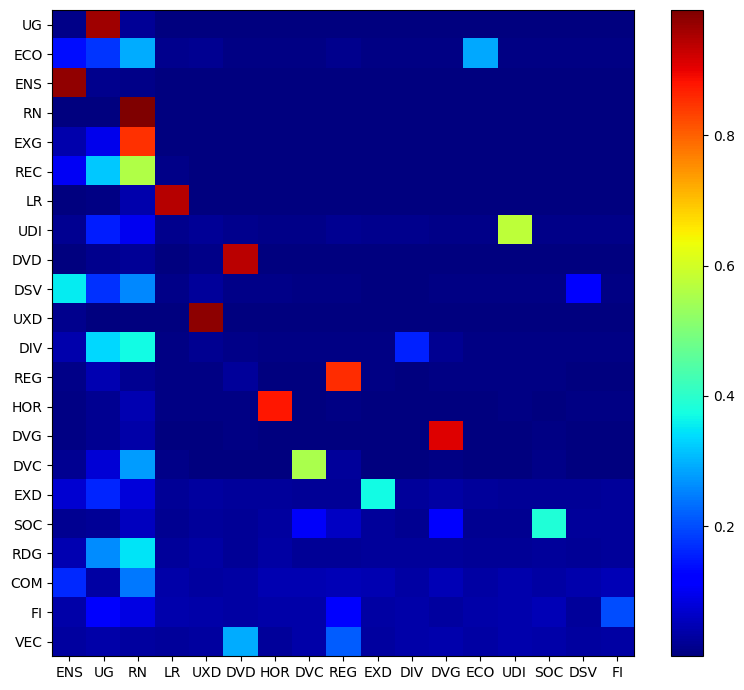

In [475]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8,7)
)
g = ax.imshow(
    Matrice,
    aspect="auto",
    cmap="jet"
)
fig.colorbar(
    g,
    ax=ax
)
ax.set_xticks(
    range(df_2f.keys()[:-1].shape[0]),
    df_2f.keys()[:-1]
)
ax.set_yticks(
    range(df_1f.keys()[:-1].shape[0]),
    df_1f.keys()[:-1]
)
plt.tight_layout()
plt.show()

In [476]:
T_df_1f = torch.Tensor(df_1f[df_1f.keys()[:-1]].to_numpy() / df_1f[df_1f.keys()[:-1]].to_numpy().sum(axis=1)[:,None])
T_Matrice = torch.Tensor(Matrice)
print(T_df_1f.shape, T_Matrice.shape)

torch.Size([61593, 22]) torch.Size([22, 17])


In [477]:
pred_T_df_2f = T_df_1f @ T_Matrice
print(pred_T_df_2f.shape)

torch.Size([61593, 17])


In [478]:
pred_winner = df_2f.keys()[np.argmax(pred_T_df_2f, axis=1).numpy()]
winner = df_2f.keys()[np.argmax(df_2f[df_2f.keys()[:-1]].to_numpy(), axis=1)]

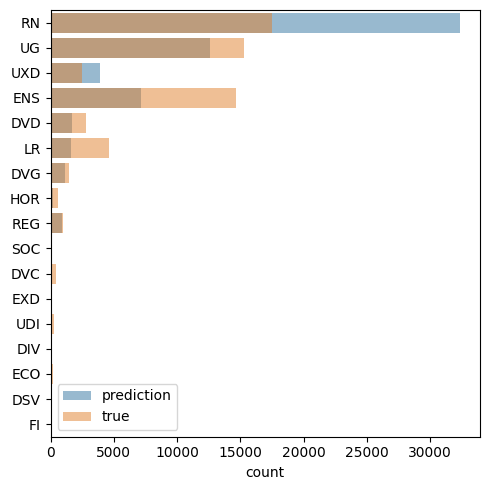

In [479]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
    dpi=100
)
sns.countplot(
    pred_winner,
    alpha=0.5,
    label="prediction",
    ax=ax
)
sns.countplot(
    winner,
    alpha=0.5,
    label="true",
    ax=ax
)
ax.legend()
plt.tight_layout()
plt.show()

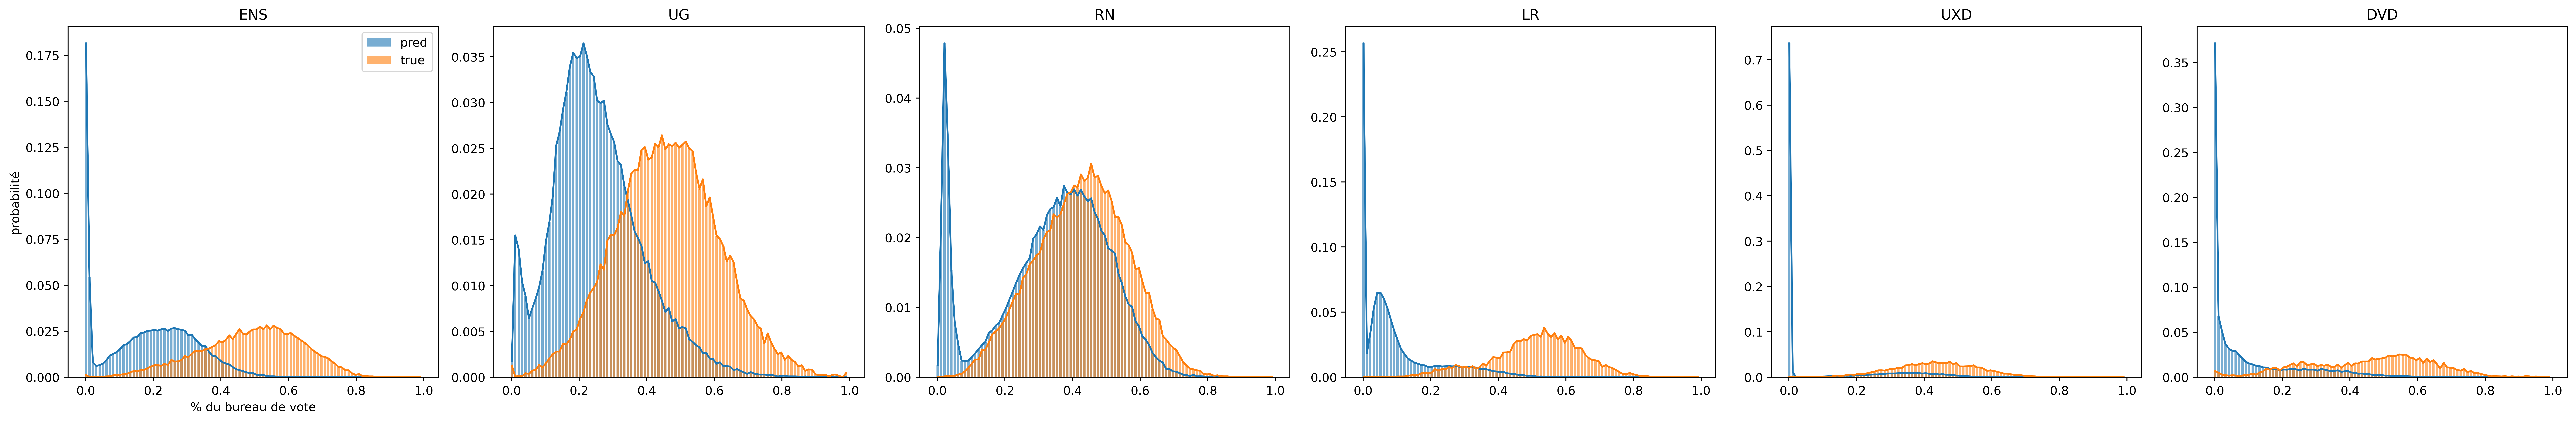

In [480]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=6, #pred_T_df_2f.shape[-1],
    figsize=(30,5),
    dpi=500
)

for i in range(6):#range(pred_T_df_2f.shape[-1]):
    
    # Prédiction
    to_plot = pred_T_df_2f[:,i].numpy()
    values, bins = np.histogram(
        a=to_plot, 
        bins=np.linspace(0.001, 1, 100)
    )
    ax[i].bar(
        x=bins[:-1],
        height=values/values.sum(),
        width=(bins[1]-bins[0])/1.5,
        alpha=0.6,
        label="pred"
    )
    ax[i].plot(
        bins[:-1],
        values/values.sum(),
        alpha=1
    )

    # Réalité
    values, bins = np.histogram(
        a=df_2f[df_2f.keys()[i]] / df_2f[df_2f.keys()[:-1]].sum(axis=1), 
        bins=np.linspace(0.001, 1, 100)
    )
    ax[i].bar(
        x=bins[:-1],
        height=values/values.sum(),
        width=(bins[1]-bins[0])/1.5,
        alpha=0.6,
        label="true"
    )
    ax[i].plot(
        bins[:-1],
        values/values.sum(),
        alpha=1
    )
    ax[i].set_title(
        df_2f.keys()[i]
    )
    
    # ax[i].set_yscale("log")

ax[0].legend()
ax[0].set_ylabel("probabilité")
ax[0].set_xlabel("% du bureau de vote")

plt.tight_layout()
plt.savefig(
    os.path.join(prm.figures_path, "Distribution_bv_pred_true_2nd_tour.pdf"),
    dpi=500
)
plt.show()

In [482]:
Matrice.shape

(22, 17)

In [508]:
import matplotlib.cm as cm
cmap = cm.tab20

In [511]:
Matrice_norm = Matrice / Matrice.sum(axis=0) * 100

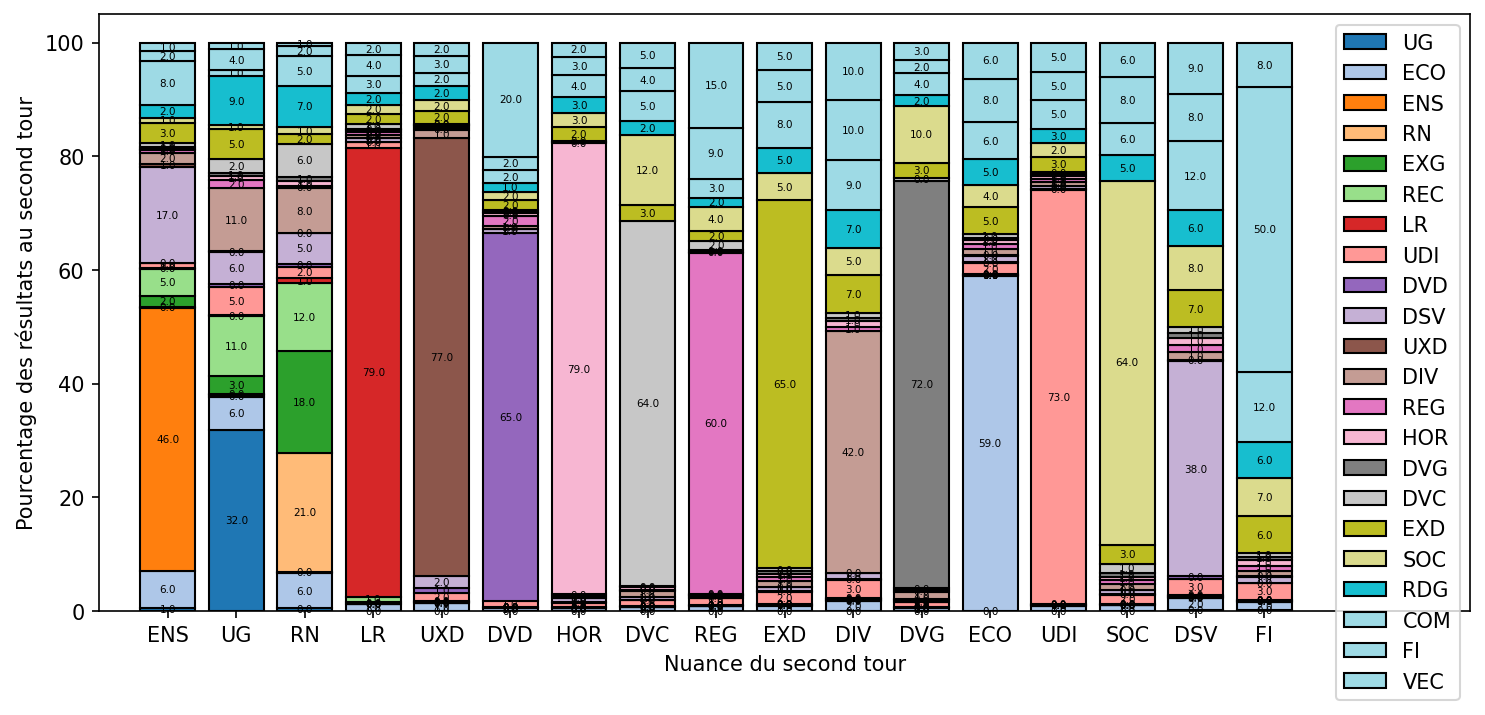

In [516]:
fig,ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(10,5),
    dpi=150
)

for i in range(Matrice.shape[0]):
    
    b = ax.bar(
        df_2f.keys()[:-1],
        height=Matrice_norm[i,:],
        bottom=Matrice_norm[:i,:].sum(axis=0),
        label=df_1f.keys()[i],
        color=cmap(i),
        edgecolor="black",
        linewidth=1
    )
    ax.bar_label(
        b,
        np.round(Matrice_norm[i,:]),
        label_type="center",
        size=5
    )
ax.set_ylabel("Pourcentage des résultats au second tour")
ax.set_xlabel("Nuance du second tour")
ax.set_xlim(-1,19)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(prm.figures_path, "Total-Matrice-Participation.pdf"))
plt.show()

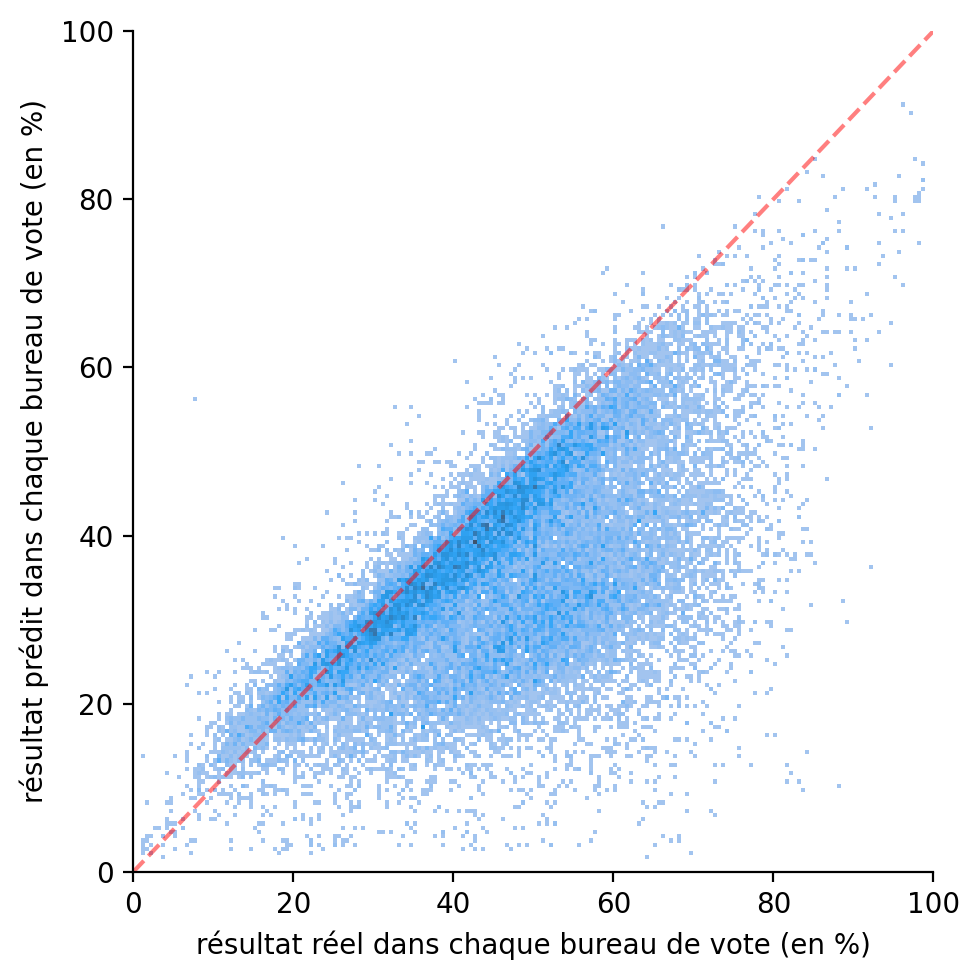

In [469]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
    dpi=200
)
sns.histplot(
    x=Test.reshape(Test.shape[0]*Test.shape[1]), 
    y=Pred.reshape(Pred.shape[0]*Pred.shape[1]),
    binrange=(1,99),
    binwidth=0.5,
    ax=ax
    )
ax.plot(
    [0,100],
    [0,100],
    linestyle="dashed",
    color="red",
    alpha=0.5
)
ax.set_xlabel("résultat réel dans chaque bureau de vote (en %)")
ax.set_ylabel("résultat prédit dans chaque bureau de vote (en %)")
ax.spines[["top","right"]].set_visible(False)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig(os.path.join(prm.figures_path, "Total_True_Pred_Hist.pdf"))
plt.show()

In [443]:
from sklearn.metrics import r2_score, mean_squared_error, d2_absolute_error_score
from sklearn.utils import shuffle

In [444]:
print(r2_score(Test, Pred))
print(mean_squared_error(Test, Pred))
print(d2_absolute_error_score(Test, Pred))

-1064.3834228515625
8766.655
-472.40483443395436


## Focalisation sur certains face à face

In [445]:
focus = []
for file in os.listdir(prm.results_path):
    if file[:8] == "D1_focus":
        focus.append(file)

In [446]:
Matrice = []
Test = []
Pred = []
for foc in focus:
    print(foc)
    path = os.path.join(prm.results_path, foc)
    Matrice.append(np.load(os.path.join(path, os.listdir(path)[-3])))
    Pred.append(np.load(os.path.join(path, os.listdir(path)[-2])))
    Test.append(np.load(os.path.join(path, os.listdir(path)[-1])))

D1_focus_ENS_RN_6
D1_focus_LR_RN_9
D1_focus_UG_RN_8


In [447]:
df_1f = pd.read_csv(os.path.join(prm.datasets_pp_path, f"DF_{prm.dataset_1er_tour}.csv"))
df_2f = pd.read_csv(os.path.join(prm.datasets_pp_path, f"DF_{prm.dataset_2nd_tour}.csv"))

In [448]:
Nuances_1er_tour = df_1f.keys()[:-1]
Nuances_2nd_tour = df_2f.keys()[:-1]

In [449]:
import matplotlib.pyplot as plt

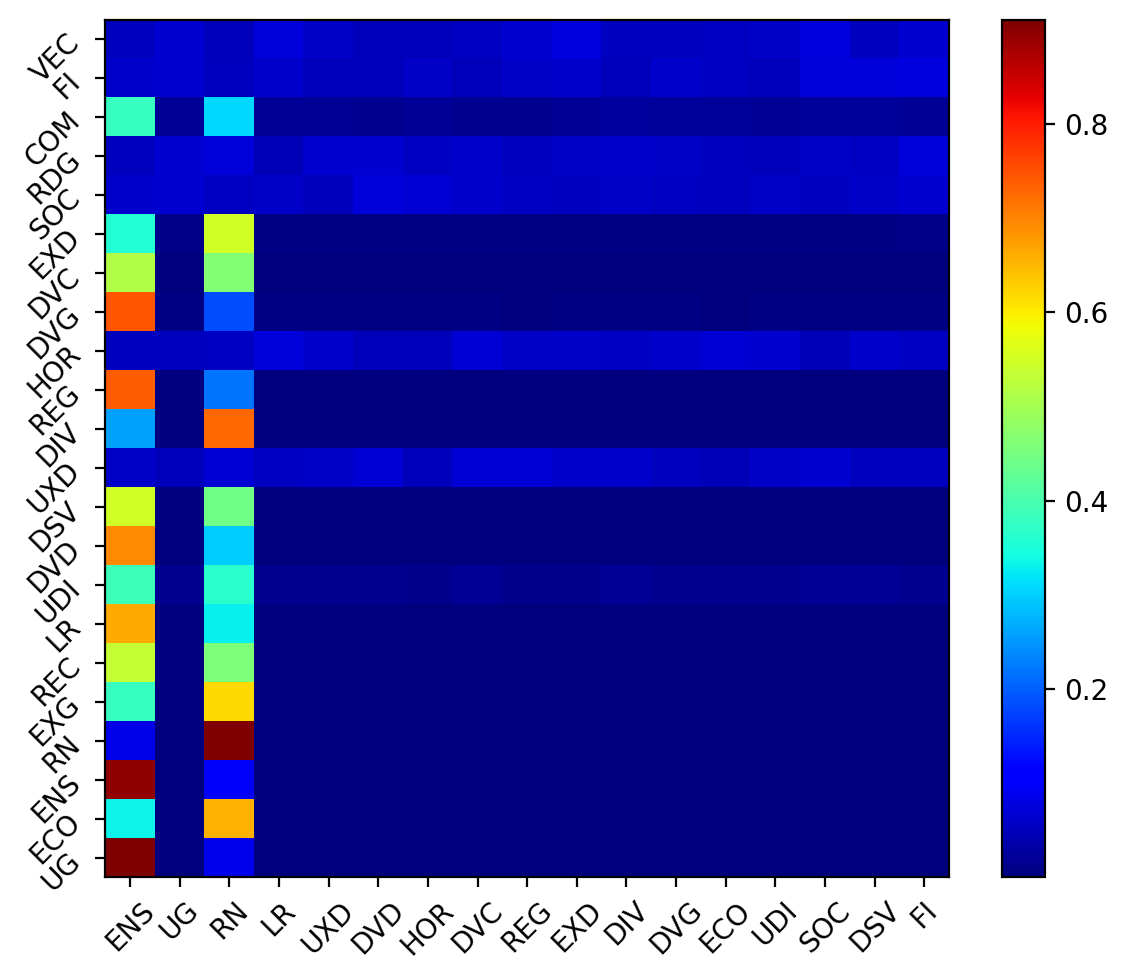

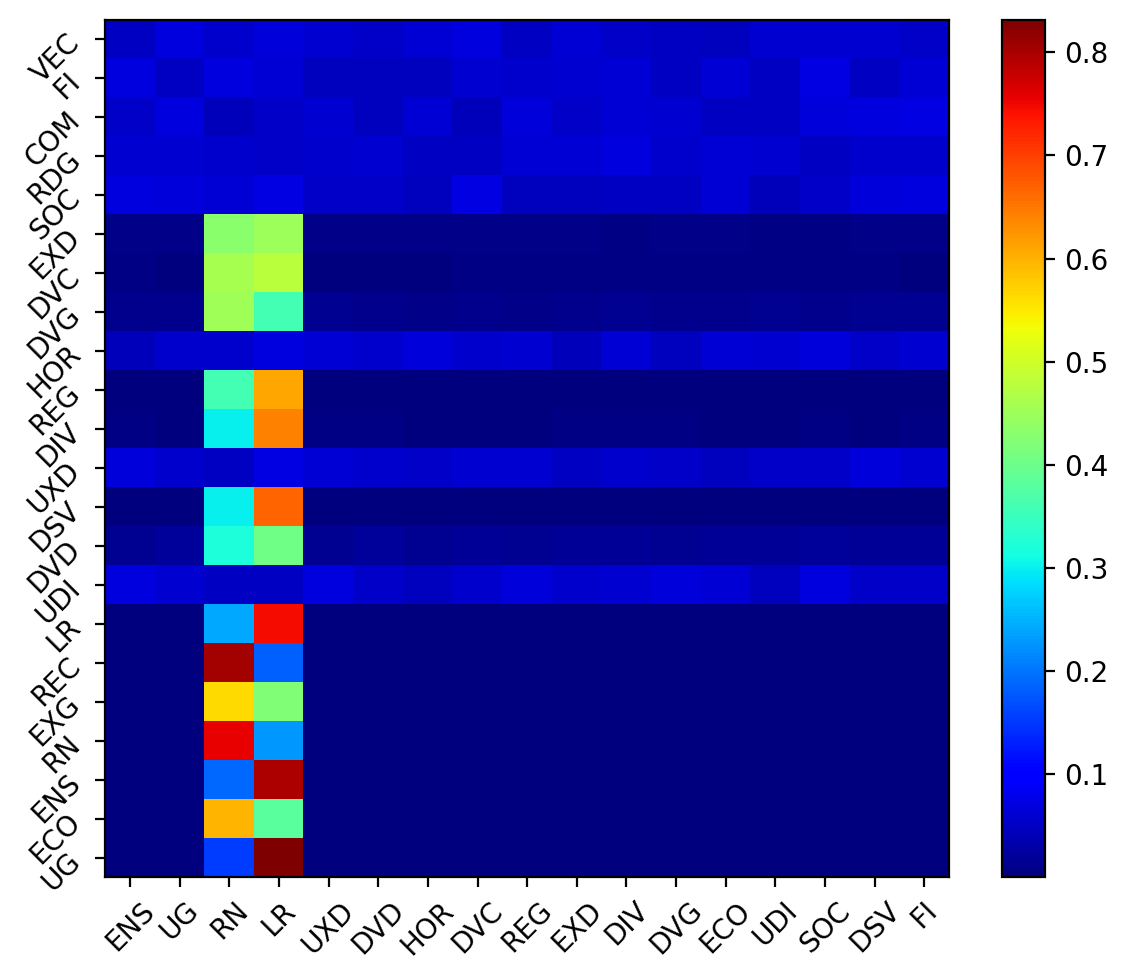

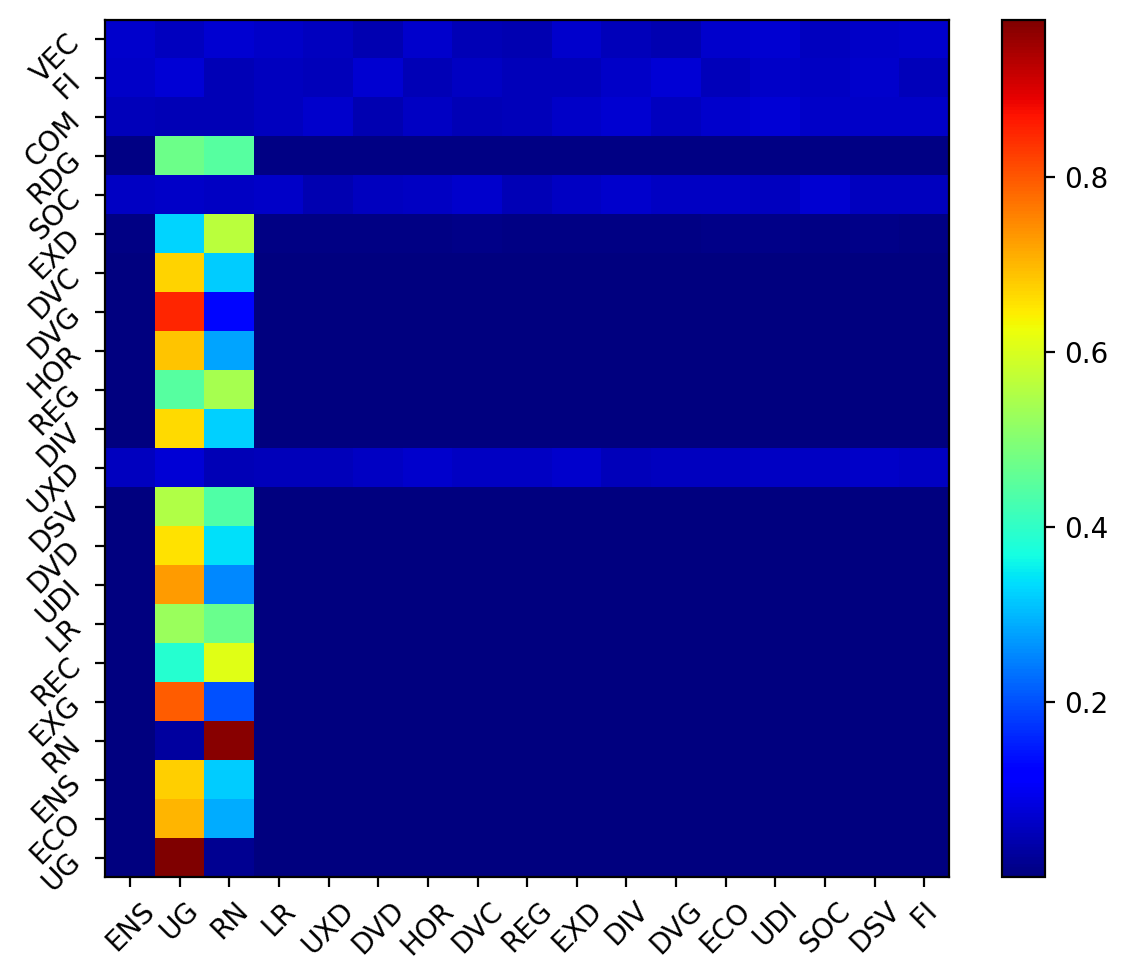

In [450]:
for i in range(len(Matrice)):
    
    fig,ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(6,5),
        dpi=200
    )

    g = ax.imshow(
        Matrice[i],
        aspect="auto",
        origin="lower",
        cmap="jet",
    )

    cbar = fig.colorbar(
        g,
        ax=ax
    )
    # cbar.set_label(
    #     "Poids / Influence",
    #     size=15
    # )
    ax.set_xticks(
        range(Matrice[i].shape[-1]),
        Nuances_2nd_tour,
        rotation=45
    )
    ax.set_yticks(
        range(Matrice[i].shape[0]),
        Nuances_1er_tour,
        rotation=45
    )
    # ax.set_ylabel(
    #     "1er tour"
    # )
    # ax.set_xlabel(
    #     "2nd tour"
    # )

    plt.tight_layout()
    plt.savefig(os.path.join(prm.figures_path, f"Focus_Matrice_{f_to_f[i]}.pdf"), dpi=150)
    plt.show()

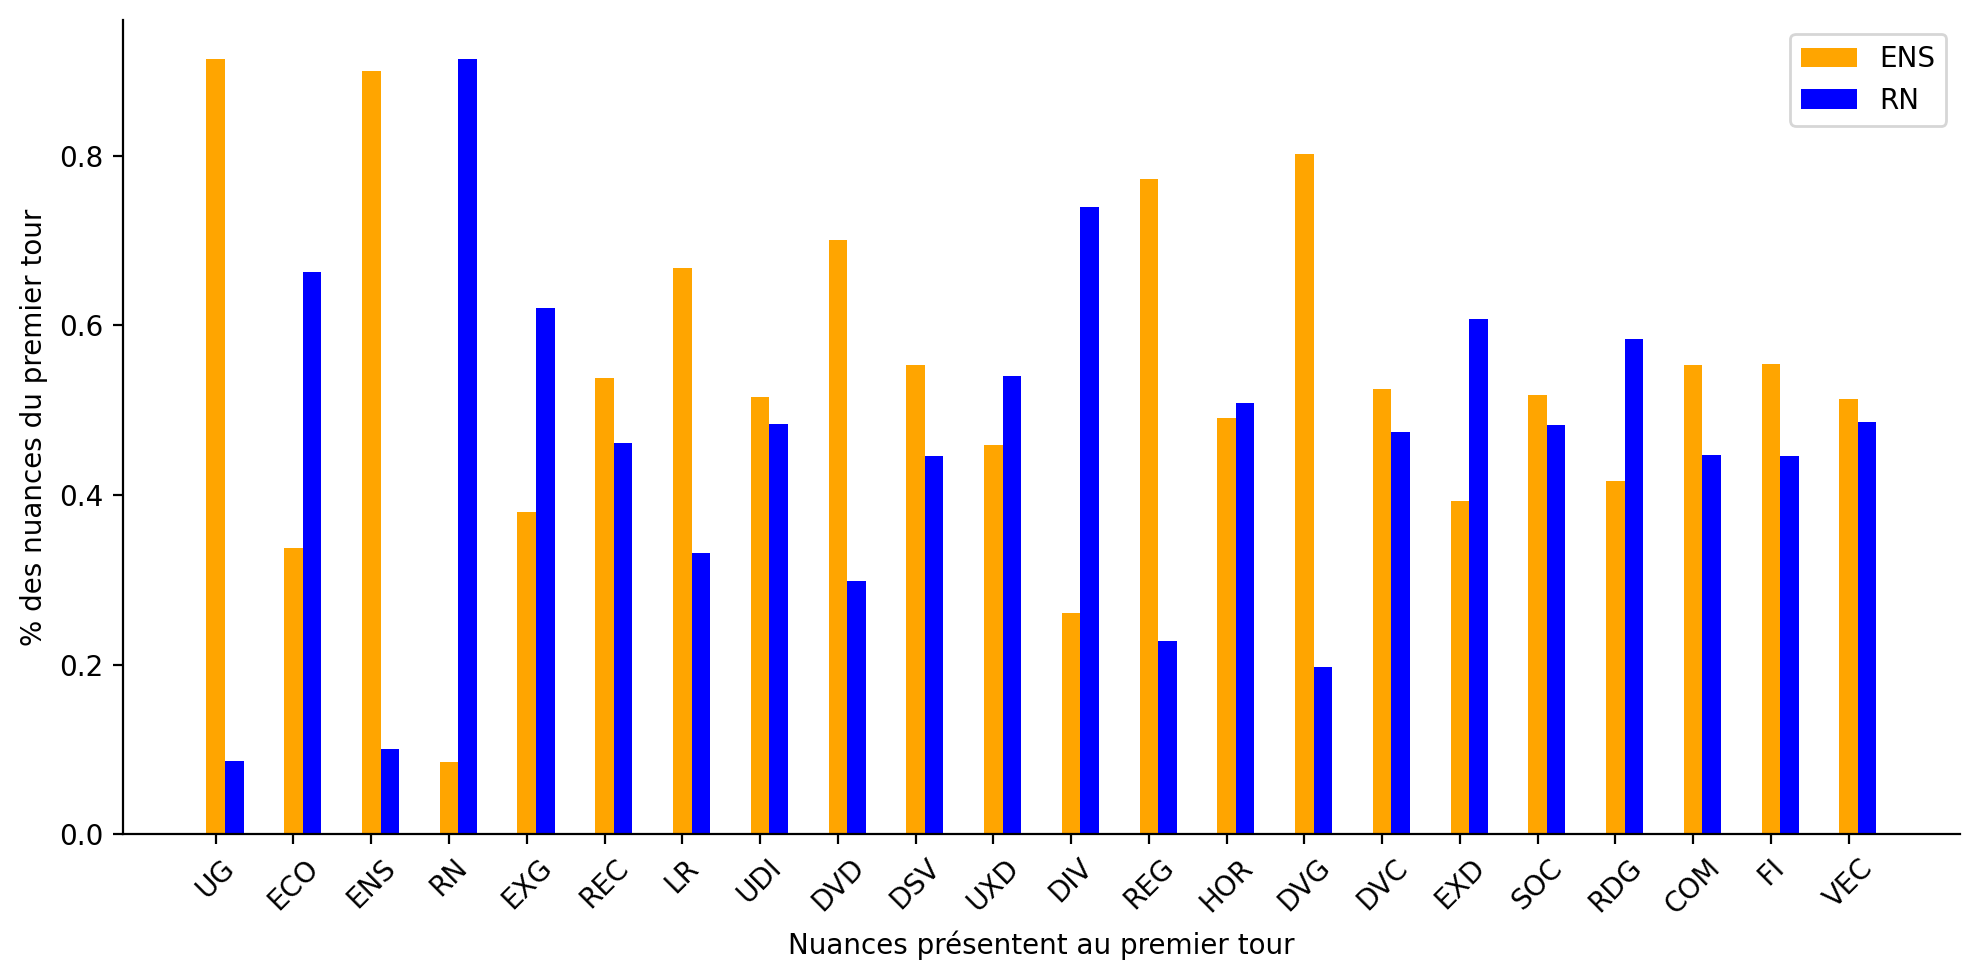

In [453]:
M_ENS_RN = np.concatenate([Matrice[0][:,:1], Matrice[0][:,2:3]], axis=1)
M_ENS_RN_norm = M_ENS_RN / M_ENS_RN.sum(axis=1)[:,None]

fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,5),
    dpi=200
)
ff = ["ENS","RN"]
colors = ["orange","blue"]
width = 0.25  # the width of the bars
offset = 0

for i in range(M_ENS_RN.shape[-1]):
    
    ax.bar(
        x = np.linspace(0, M_ENS_RN_norm.shape[0], M_ENS_RN_norm.shape[0]) + offset,
        height = M_ENS_RN_norm[:,i],
        width = width,
        color=colors[i],
        label = ff[i]
        )
    offset += width

ax.legend()
ax.set_xticks(
    np.linspace(0, M_ENS_RN_norm.shape[0], M_ENS_RN_norm.shape[0]),
    Nuances_1er_tour,
    rotation=45   
)
ax.spines[["top","right"]].set_visible(False)
# ax.set_title("Proportion de chaque partie du premier tour dans les résultats le RN ou ENS du second tour")
ax.set_xlabel("Nuances présentent au premier tour")
ax.set_ylabel("% des nuances du premier tour")
plt.tight_layout()
plt.savefig(os.path.join(prm.figures_path, "Focus_ENS_RN.pdf"), dpi=200)
plt.show()

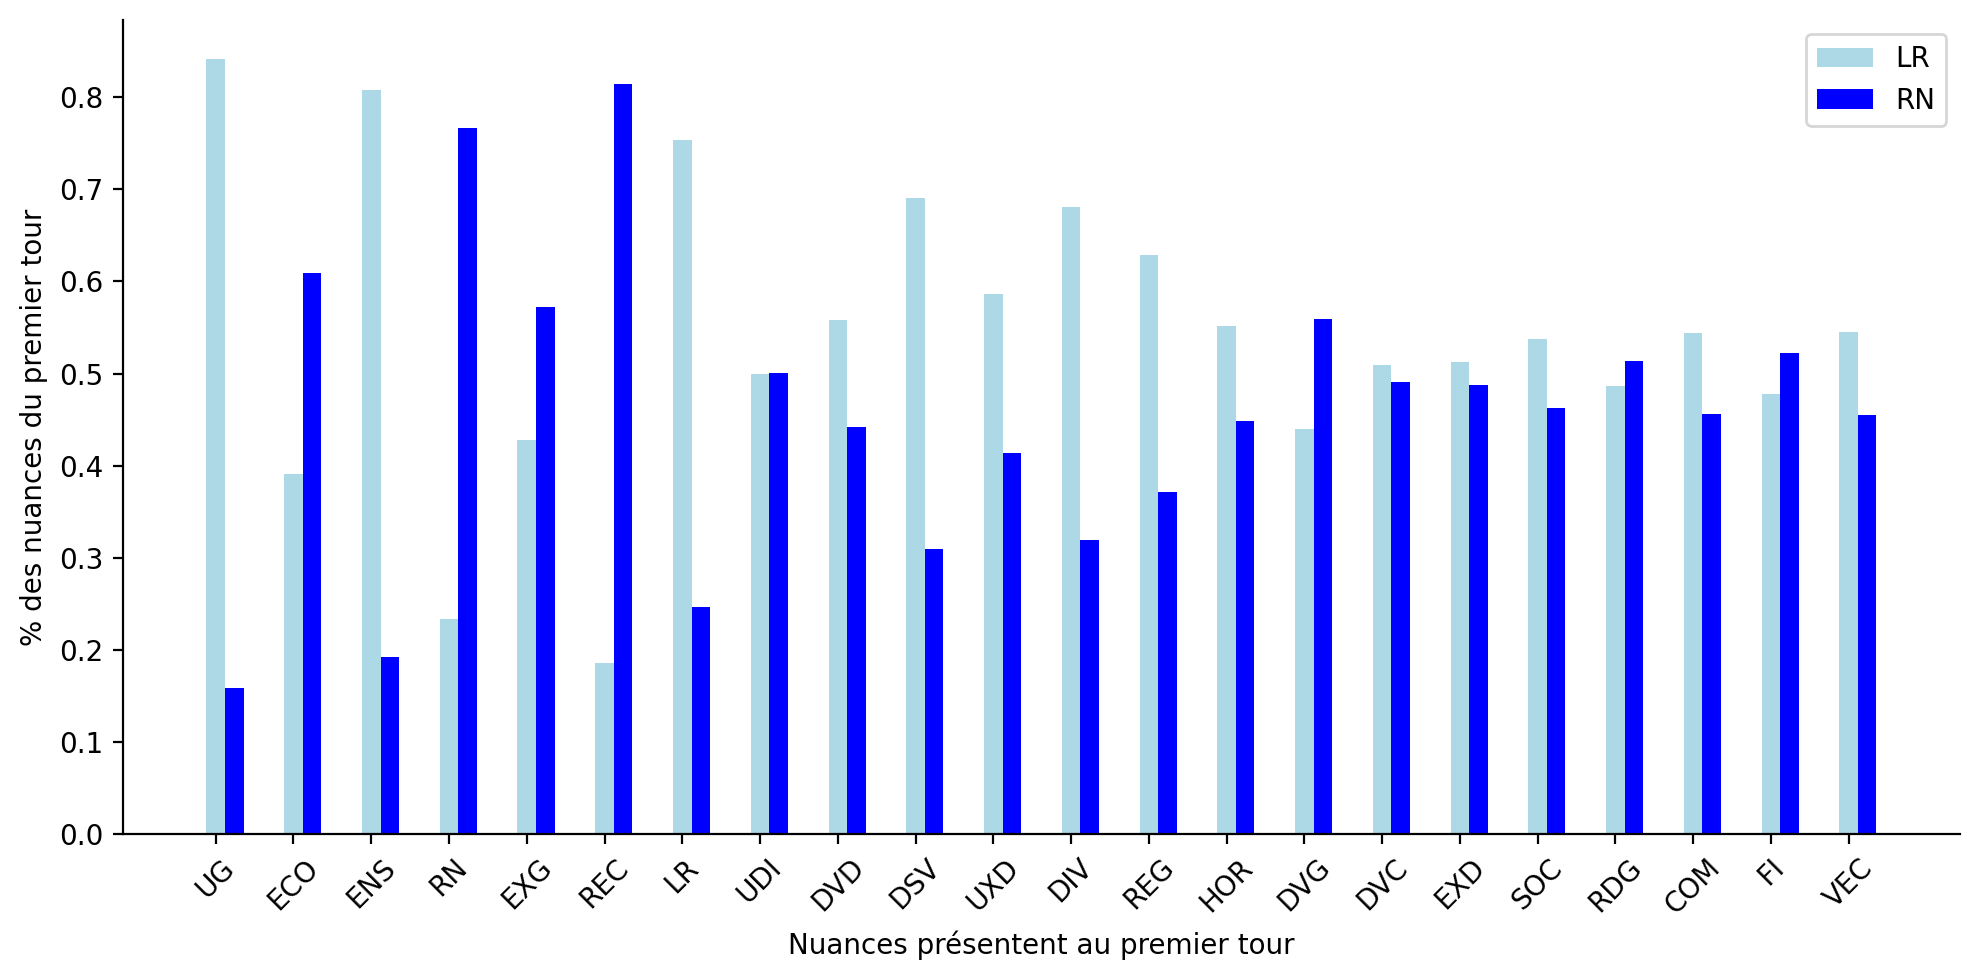

In [455]:
M_LR_RN = np.concatenate([Matrice[1][:,3:4], Matrice[1][:,2:3]], axis=1)
M_LR_RN_norm = M_LR_RN / M_LR_RN.sum(axis=1)[:,None]

fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,5),
    dpi=200
)
ff = ["LR","RN"]
colors = ["lightblue","blue"]
width = 0.25  # the width of the bars
offset = 0

for i in range(M_ENS_RN.shape[-1]):
    
    ax.bar(
        x = np.linspace(0, M_LR_RN.shape[0], M_LR_RN.shape[0]) + offset,
        height = M_LR_RN_norm[:,i],
        width = width,
        color=colors[i],
        label = ff[i]
        )
    offset += width

ax.legend()
ax.set_xticks(
    np.linspace(0, M_LR_RN.shape[0], M_LR_RN.shape[0]),
    Nuances_1er_tour,
    rotation=45
)
ax.spines[["top","right"]].set_visible(False)
# ax.set_title("Proportion de chaque partie du premier tour dans les résultats le RN ou LR du second tour")
ax.set_xlabel("Nuances présentent au premier tour")
ax.set_ylabel("% des nuances du premier tour")
plt.tight_layout()
plt.savefig(os.path.join(prm.figures_path, "Focus_LR_RN.pdf"), dpi=200)
plt.show()

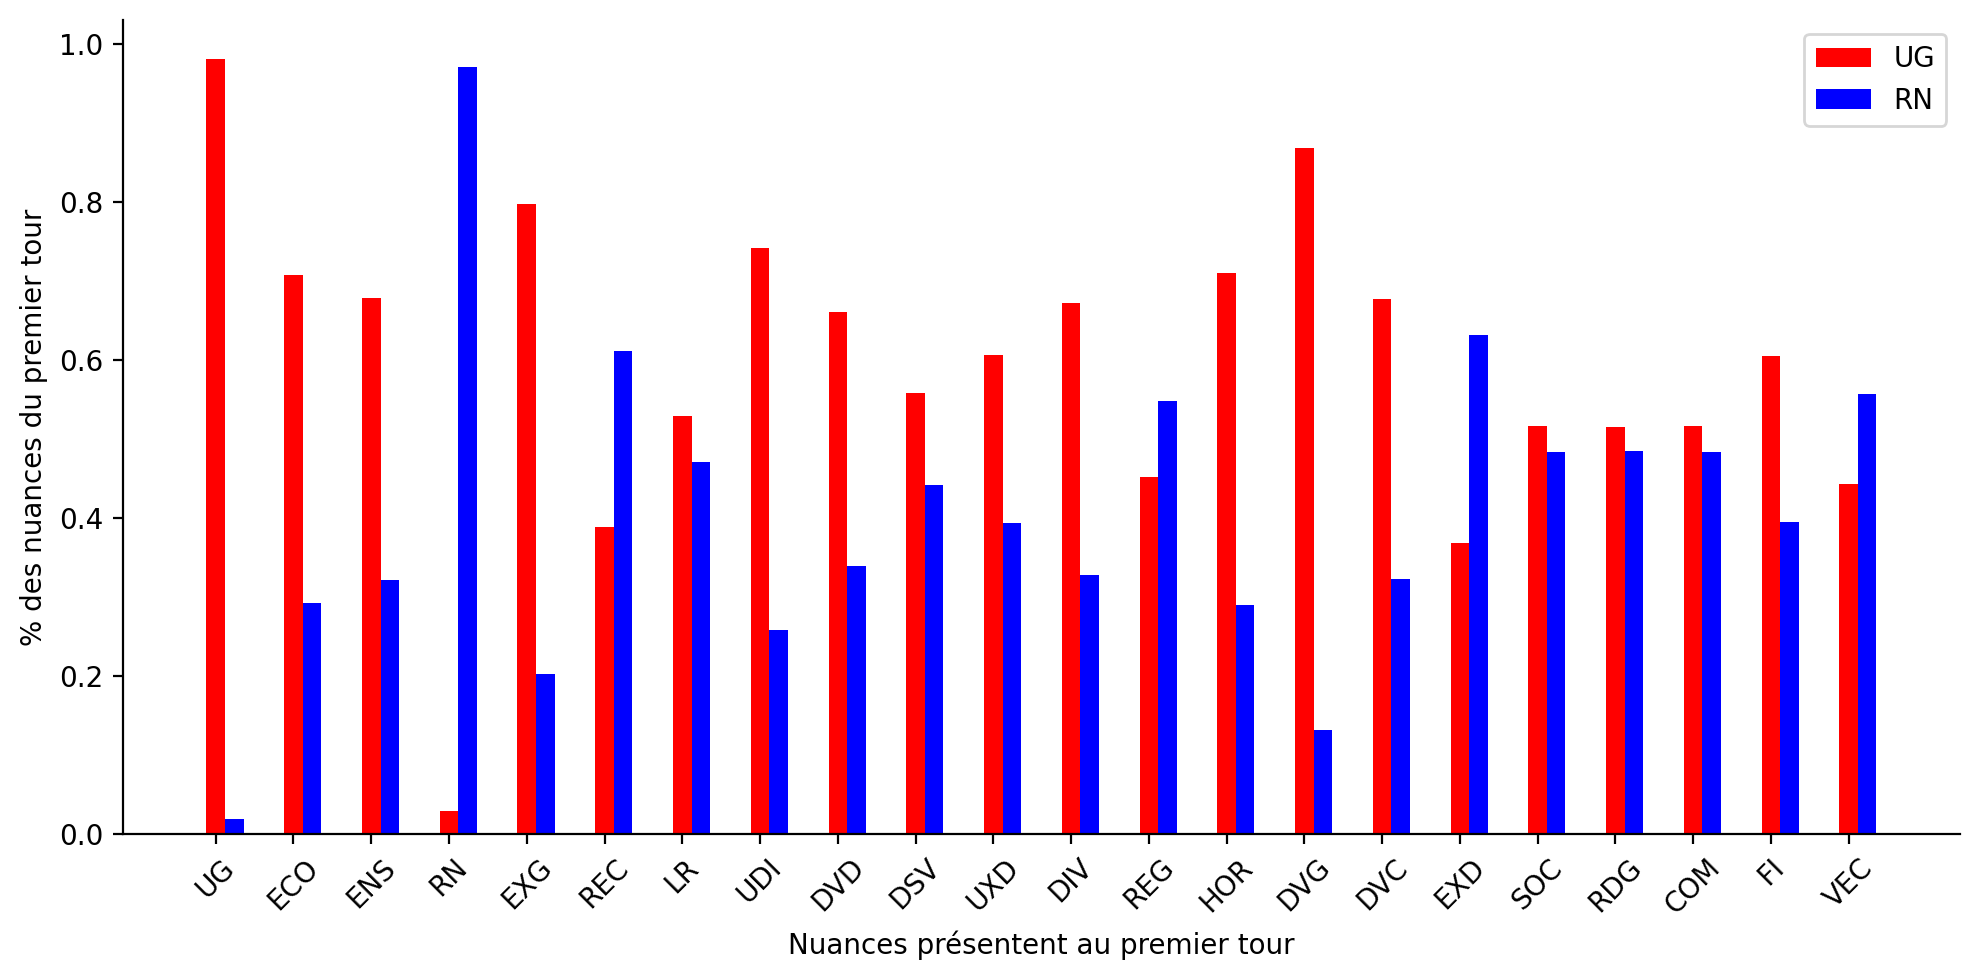

In [456]:
M_UG_RN = np.concatenate([Matrice[2][:,1:2], Matrice[2][:,2:3]], axis=1)
M_UG_RN_norm = M_UG_RN / M_UG_RN.sum(axis=1)[:,None]

fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,5),
    dpi=200
)
ff = ["UG","RN"]
colors = ["red","blue"]
width = 0.25  # the width of the bars
offset = 0

for i in range(M_UG_RN.shape[-1]):
    
    ax.bar(
        x = np.linspace(0, M_UG_RN.shape[0], M_UG_RN.shape[0]) + offset,
        height = M_UG_RN_norm[:,i],
        width = width,
        color=colors[i],
        label = ff[i]
        )
    offset += width

ax.legend()
ax.set_xticks(
    np.linspace(0, M_UG_RN.shape[0], M_UG_RN.shape[0]),
    Nuances_1er_tour,
    rotation=45  
)
ax.spines[["top","right"]].set_visible(False)
# ax.set_title("Proportion de chaque partie du premier tour dans les résultats le RN ou UG du second tour")
ax.set_xlabel("Nuances présentent au premier tour")
ax.set_ylabel("% des nuances du premier tour")
plt.tight_layout()
plt.savefig(os.path.join(prm.figures_path, "Focus_UG_RN.pdf"), dpi=200)
plt.show()

Nbr de point : 2717
r2 score =  0.10494063794612885
MSE score =  8825.222
MSE score =  8849.467
d2 score =  0.08148383196181841
d2 score shuffle =  -0.032191124020327644 

Nbr de point : 1166
r2 score =  0.08509789407253265
MSE score =  8827.546
MSE score =  8843.063
d2 score =  0.05699253586544478
d2 score shuffle =  -0.016627273931014878 

Nbr de point : 3244
r2 score =  0.10764527320861816
MSE score =  8825.288
MSE score =  8856.93
d2 score =  0.0844347431775161
d2 score shuffle =  -0.03870161660295315 



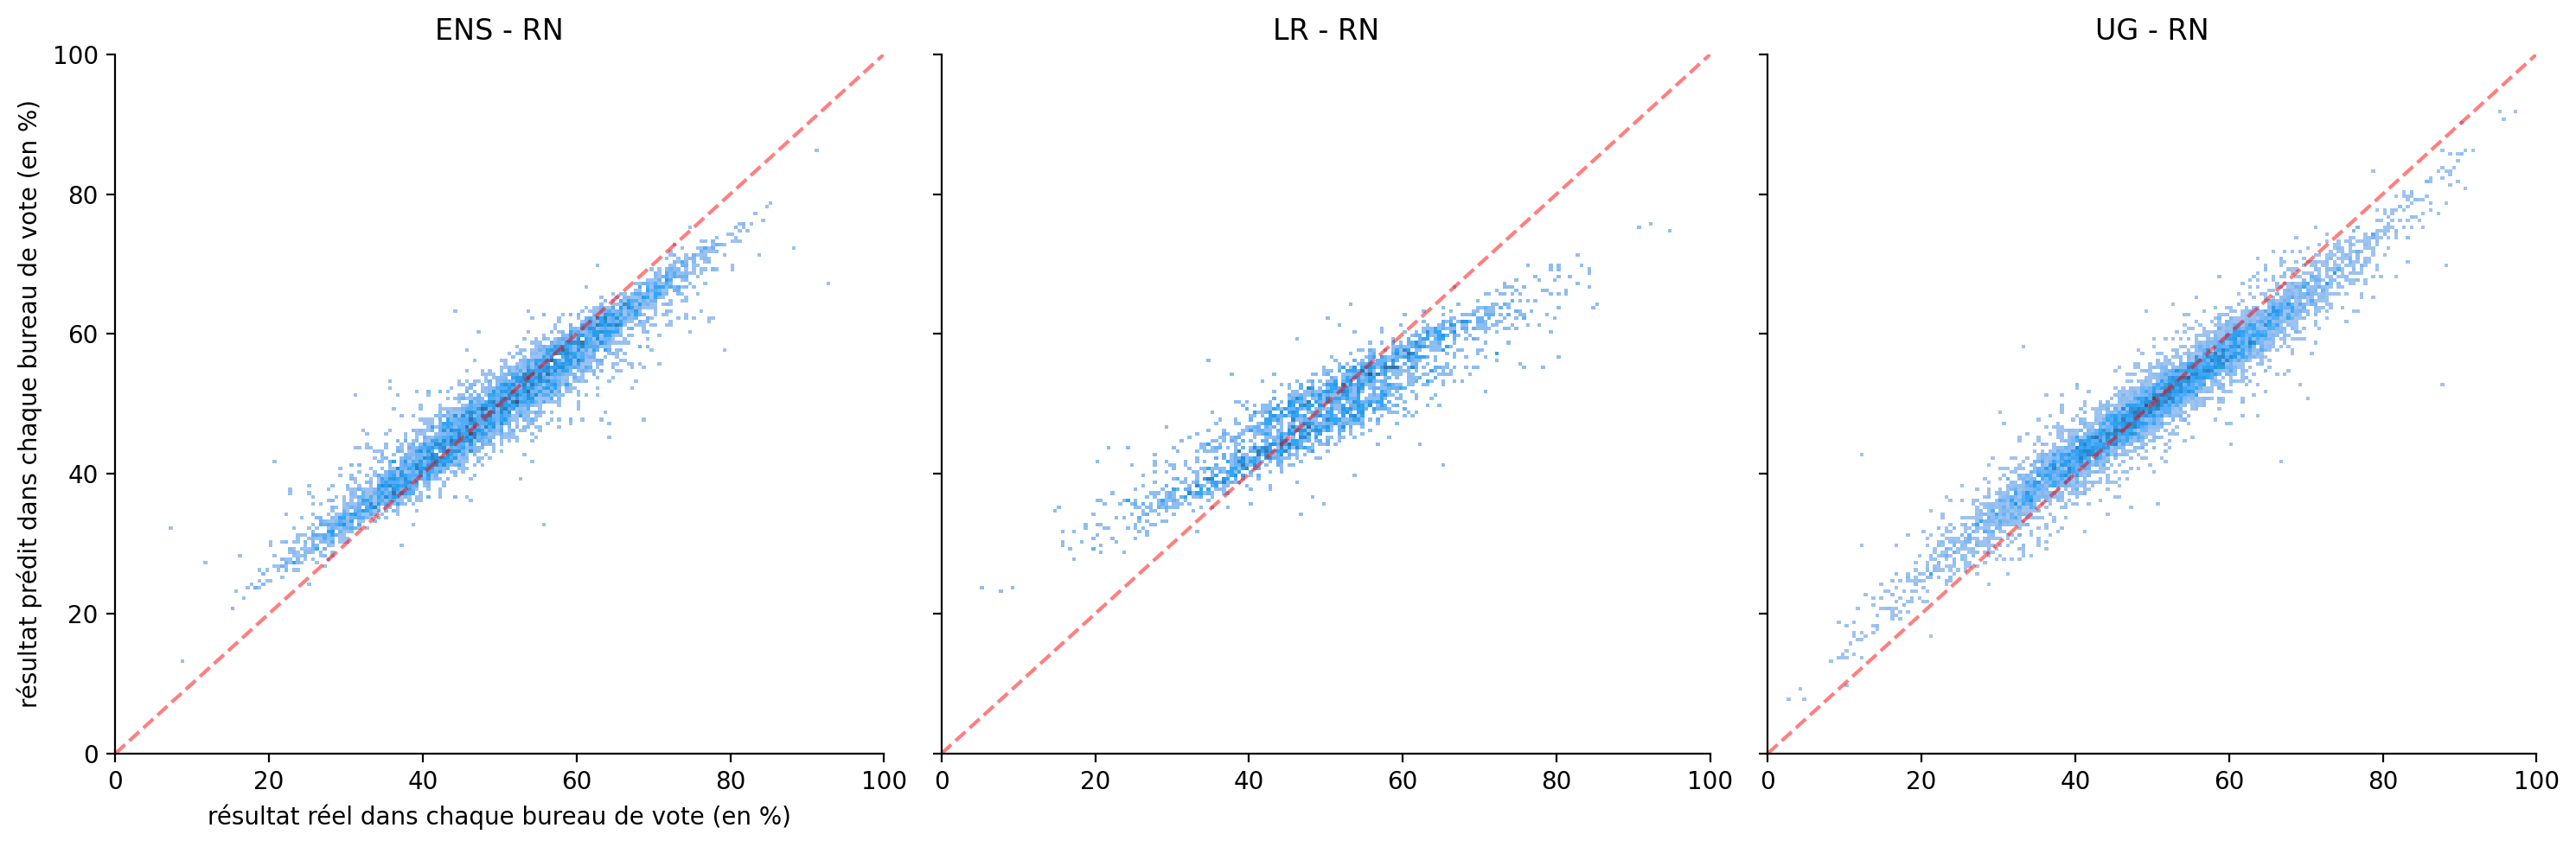

In [457]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=3,
    sharex=True,
    sharey=True,
    figsize=(15,5),
    dpi=200
)

f_to_f = ["ENS - RN", "LR - RN", "UG - RN"]

for i in range(len(Test)):

    test = Test[i] * 100
    pred = Pred[i] * 100
    
    print("Nbr de point :", test.shape[0])
    
    sns.histplot(
        x=test.reshape(test.shape[0]*test.shape[1]), 
        y=pred.reshape(pred.shape[0]*pred.shape[1]),
        binrange=(1,99),
        binwidth=0.5,
        ax=ax[i]
        )
    ax[i].plot(
        [0,100],
        [0,100],
        linestyle="dashed",
        color="red",
        alpha=0.5
    )
    ax[i].spines[["top","right"]].set_visible(False)
    ax[i].set_title(f_to_f[i])
    
    print("r2 score = ", r2_score(test, pred))
    print("MSE score = ", mean_squared_error(test, pred))
    print("MSE score = ", mean_squared_error(shuffle(test), pred))
    print("d2 score = ", d2_absolute_error_score(test, pred))
    print("d2 score shuffle = ", d2_absolute_error_score(shuffle(test), pred), "\n")

ax[0].set_xlabel("résultat réel dans chaque bureau de vote (en %)")
ax[0].set_ylabel("résultat prédit dans chaque bureau de vote (en %)")
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 100)

plt.tight_layout()
plt.savefig(os.path.join(prm.figures_path, "Focus_True_Pred_Hist.pdf"))
plt.show()

## Simplification du problème en ne considérant des "familles" politiques

In [349]:
famille = []
for file in os.listdir(prm.results_path):
    if file[3:9] == "simple":
        famille.append(file)

In [350]:
famille

['D1_simple_13', 'D1_simple_15', 'D1_simple_16', 'D1_simple_17']

In [351]:
for fam in famille[:1]:
    print(fam)
    path = os.path.join(prm.results_path, fam)
    Matrice = np.load(os.path.join(path, os.listdir(path)[-3]))
    Loss_train = np.load(os.path.join(path, os.listdir(path)[-4]))
    Loss_val = np.load(os.path.join(path, os.listdir(path)[-5]))
    Pred = np.load(os.path.join(path, os.listdir(path)[-2])) * 100
    Test = np.load(os.path.join(path, os.listdir(path)[-1])) * 100

D1_simple_13


In [285]:
Familles = ["CENTRE+","EXTDROITE+","GAUCHE+","EXTGAUCHE+","DROITE+","DIV+"]

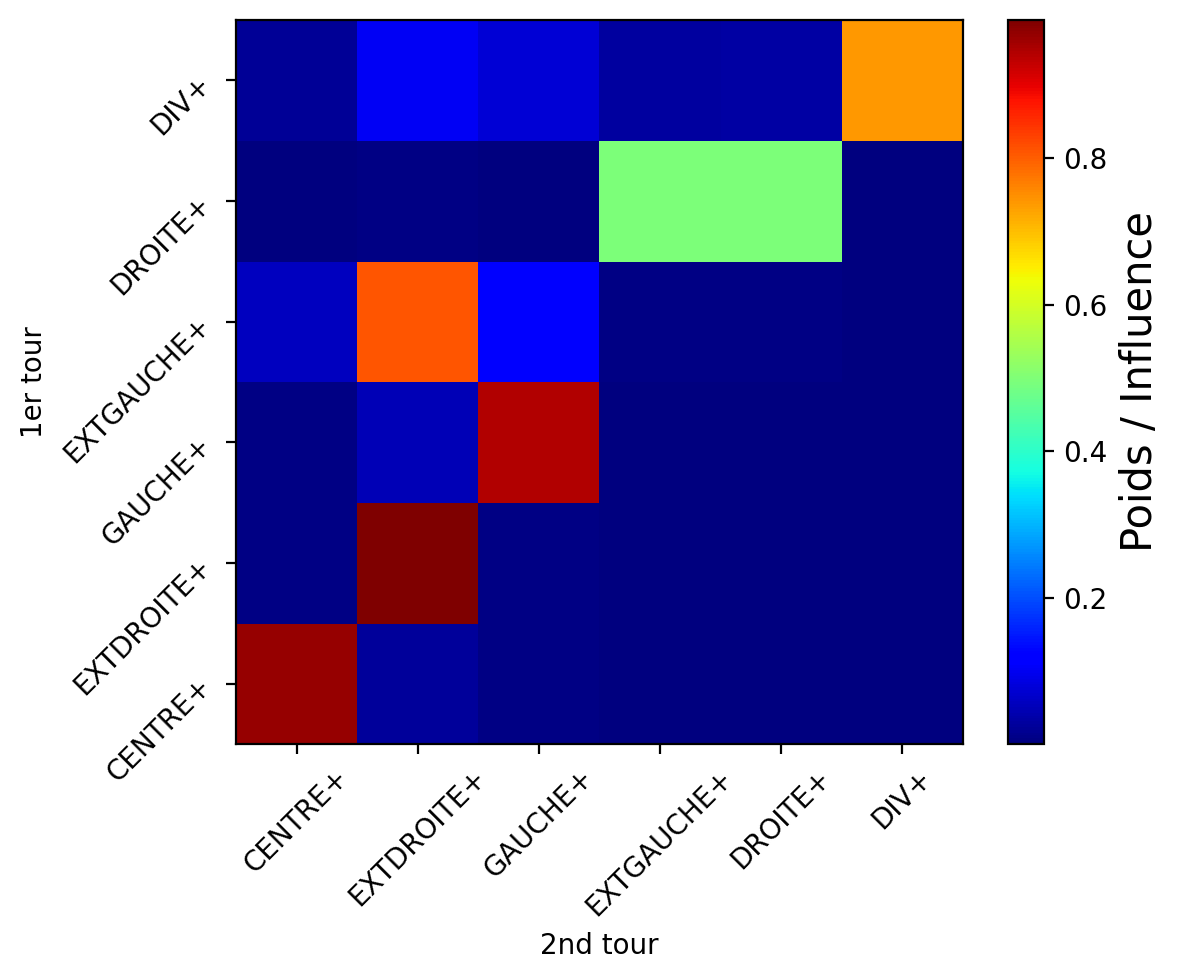

In [286]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6,5),
    dpi=200
)

g = ax.imshow(
    Matrice,
    aspect="auto",
    origin="lower",
    cmap="jet",
)

cbar = fig.colorbar(
    g,
    ax=ax
)
cbar.set_label(
    "Poids / Influence",
    size=15
)
ax.set_xticks(
    range(Matrice.shape[0]),
    Familles,
    rotation=45
)
ax.set_yticks(
    range(Matrice.shape[0]),
    Familles,
    rotation=45
)
ax.set_ylabel(
    "1er tour"
)
ax.set_xlabel(
    "2nd tour"
)
# ax.set_title(
#     "Influence des familles du premiers tour sur le résultats \n de chaque famille du second tour.",
#     size=15
# )
plt.tight_layout()
plt.savefig(os.path.join(prm.figures_path, "Famille_Matrice.pdf"), dpi=150)
plt.show()

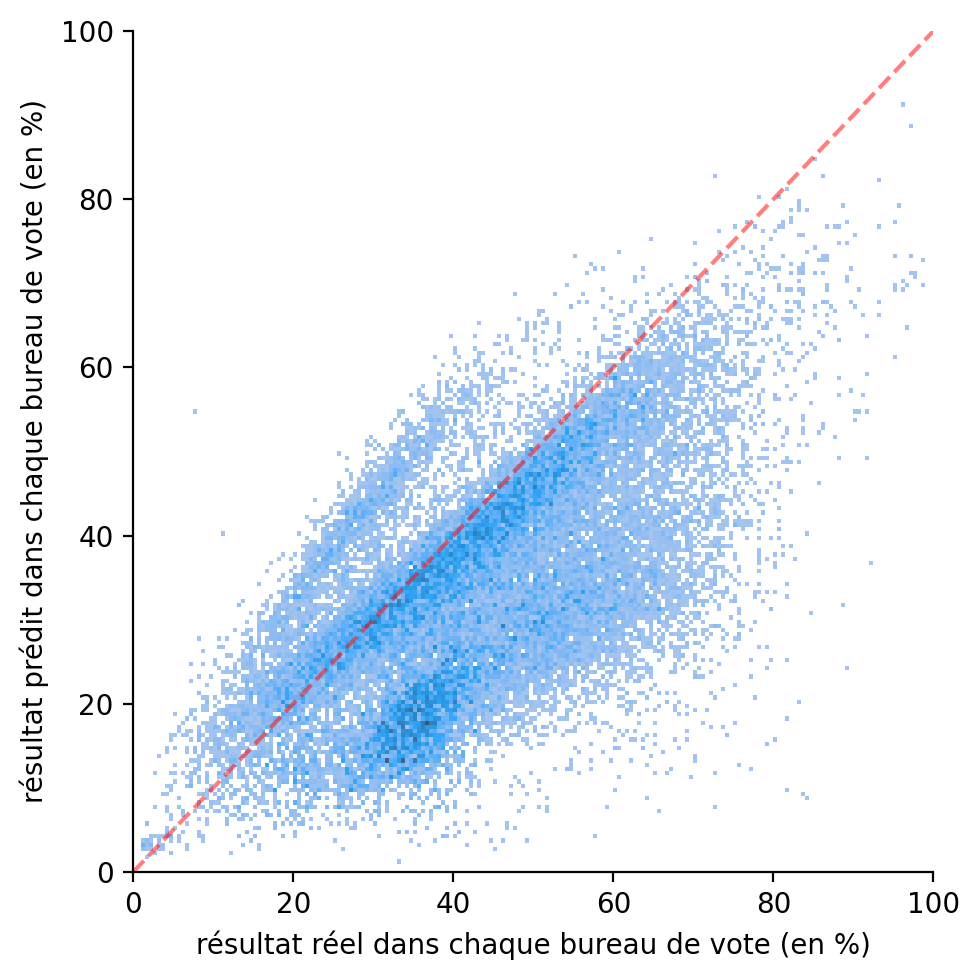

In [287]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
    dpi=200
)
sns.histplot(
    x=Test.reshape(Test.shape[0]*Test.shape[1]), 
    y=Pred.reshape(Pred.shape[0]*Pred.shape[1]),
    binrange=(1,99),
    binwidth=0.5,
    ax=ax
    )
ax.plot(
    [0,100],
    [0,100],
    linestyle="dashed",
    color="red",
    alpha=0.5
)
ax.set_xlabel("résultat réel dans chaque bureau de vote (en %)")
ax.set_ylabel("résultat prédit dans chaque bureau de vote (en %)")
ax.spines[["top","right"]].set_visible(False)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig(os.path.join(prm.figures_path, "Famille_True_Pred_Hist.pdf"))
plt.show()

In [352]:
import matplotlib.cm as cm
cmap = prm.cm.tab20

In [392]:
Matrice_norm = Matrice / Matrice.sum(axis=0) * 100

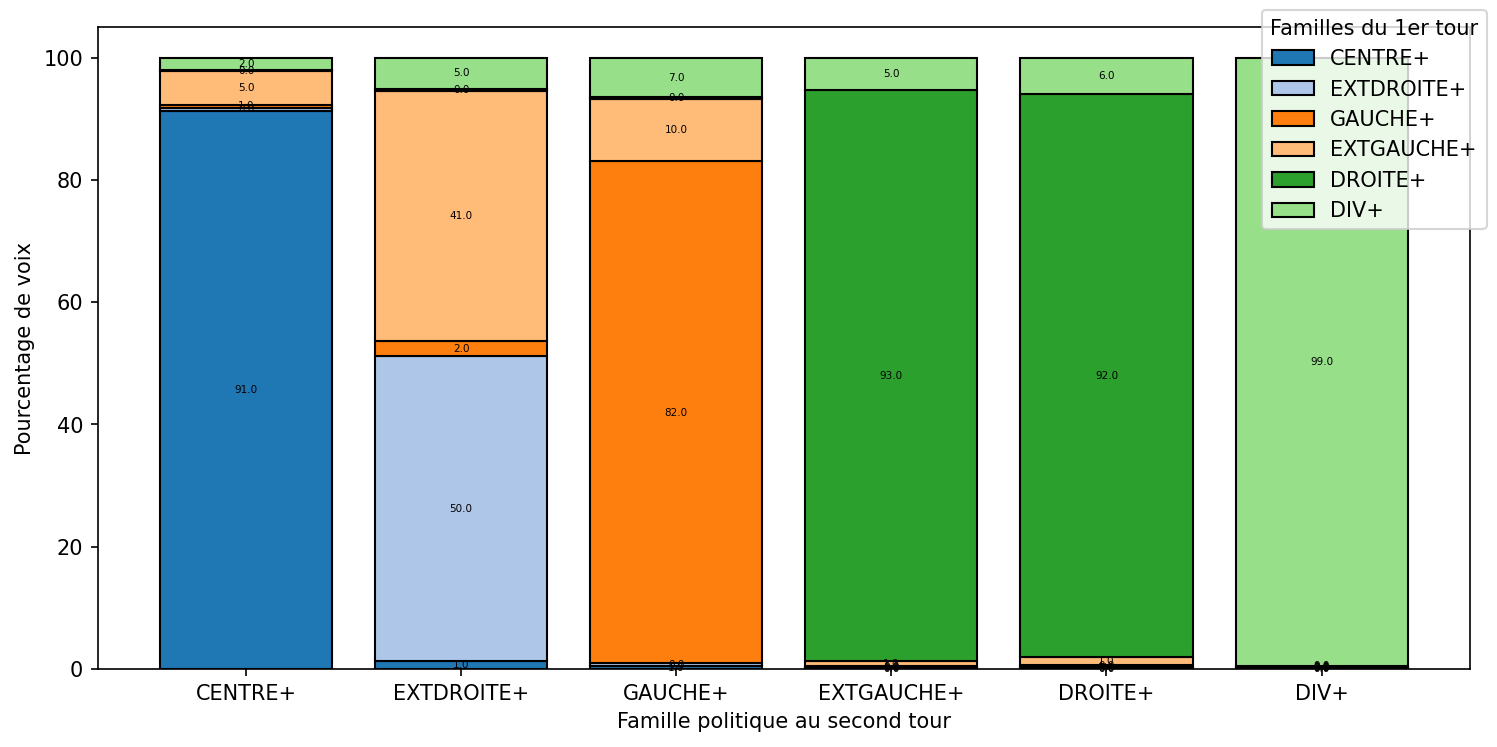

In [402]:
fig,ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(10,5),
    dpi=150
)

for i in range(Matrice_norm.shape[-1]):
    
    b = ax.bar(
        Familles,
        height=Matrice_norm[i,:],
        bottom=Matrice_norm[:i,:].sum(axis=0),
        label=Familles[i],
        color=cmap(i),
        edgecolor="black",
        linewidth=1
    )
    ax.bar_label(
        b,
        np.round(Matrice_norm[i,:]),
        label_type="center",
        size=5
    )
ax.set_xlabel("Famille politique au second tour")
ax.set_ylabel("Pourcentage de voix")

fig.legend(title="Familles du 1er tour")
plt.tight_layout()
plt.savefig(os.path.join(prm.figures_path, "Famille_Proportions.pdf"))
plt.show()

In [288]:
print(r2_score(Test, Pred))
print(mean_squared_error(Test, Pred))

-32.55524826049805
6170.6577
